# Homework 7: Southern Ocean Reentrant Channel

#### Objective:
In this homework, we will investigate the effect of resolution on transient features and transport quantities using the Southern Ocean Reentrant Channel model.

#### Import Modules:
Begin by importing the modules to read in data, conduct calculations, and make plots.

In [1]:
# import the modules you need here - you may need to add as you go
import os
import numpy as np
import matplotlib.pyplot as plt

import cmocean.cm as cm

# this module will help organize your subplots
from matplotlib.gridspec import GridSpec

# this module will be used to mask out bathymetry features
from matplotlib.patches import Polygon

## Part 1: Modify, Compile and Run the Model

In this assignment, we are going to run the same model we ran in class - but this time, we will run at a resolution which is 10x higher than before. Follow the steps below to get the high resolution model set up.

#### Step 1: Clean Build and Run directories
For this model, we're going to need some clean build and run directories. If you already downloaded everything from the low resolution models in class, you can just remove all of the existing files in your run and bulid directories. Alternatively, you can make new versions e.g.

```
MITgcm/verification/tutorial_reentrant_channel
mkdir build_hires
mkdir run_hires
```

If you choose this option, be sure to replace "build" and "run" in the lines below with these new directories.

#### Step 2: Recompile the model

To compile the model for higher resolution, we're going to need to resize our domain. The new domain size is stored in the `SIZE.h_eddy` file in the code directory. To make this change, move to your code directory and then rename the SIZE.h_eddy file to SIZE.h. Then, in your build directory, compile with MPI.

#### Step 3: Prepare your run directory
To start, per the usual set up, copy everything from input to your run directory and link the `mitgcmuv` from build to run.

Then, on your local machine, run the `gendata.5km.py` script provided with the model input files. This should create the following files:
- SST_relax.5km.bin
- T_relax_mask.5km.bin
- bathy.5km.bin
- temperature.5km.bin
- zonal_wind.5km.bin

In addition, grab the pickup files from Canvas provided with this notebook and upload them to Spartan in your run directory.
  
Make a copy of these files in your run directory on Spartan.

Next, modify the following data* files:

1. Modify the data.pkg file to uncomment the line useGMRedi=.FALSE.,

2. Modify the data file to un/comment the lines for "eddy-permitting run":
- 4 lines in PARM01 
- comment out line for viscAh=2000 in parm01
- deltaT, nTimesteps, monitorFreq in PARM03
- delX and delY in PARM04
- 4x files in PARM05
  
3. Modify the data file to start at iteration 3483648 and run for two years (1 year = 360 days).

4. Modify the data.rbcs file to use the new lines

5. Modify the data.diagnostics file to be the same as that shown in class

#### Run the model
To run the model, you'll need to make a new job script. Consider the following questions:
- How many CPUs (tasks) will you need? 
- Each node is 28 CPUs. How many nodes will you need? 

If you are in doubt, send Mike an email.

Note: this model run will take a couple hours!

## Part 3: Mean Hydrography
Again using your output from the high-resolution model, create a plot that shows mean properties along the channel ridge. You plot should have 8 panels - the 4 from class in one row, and the 4 from the new model in the bottom row.

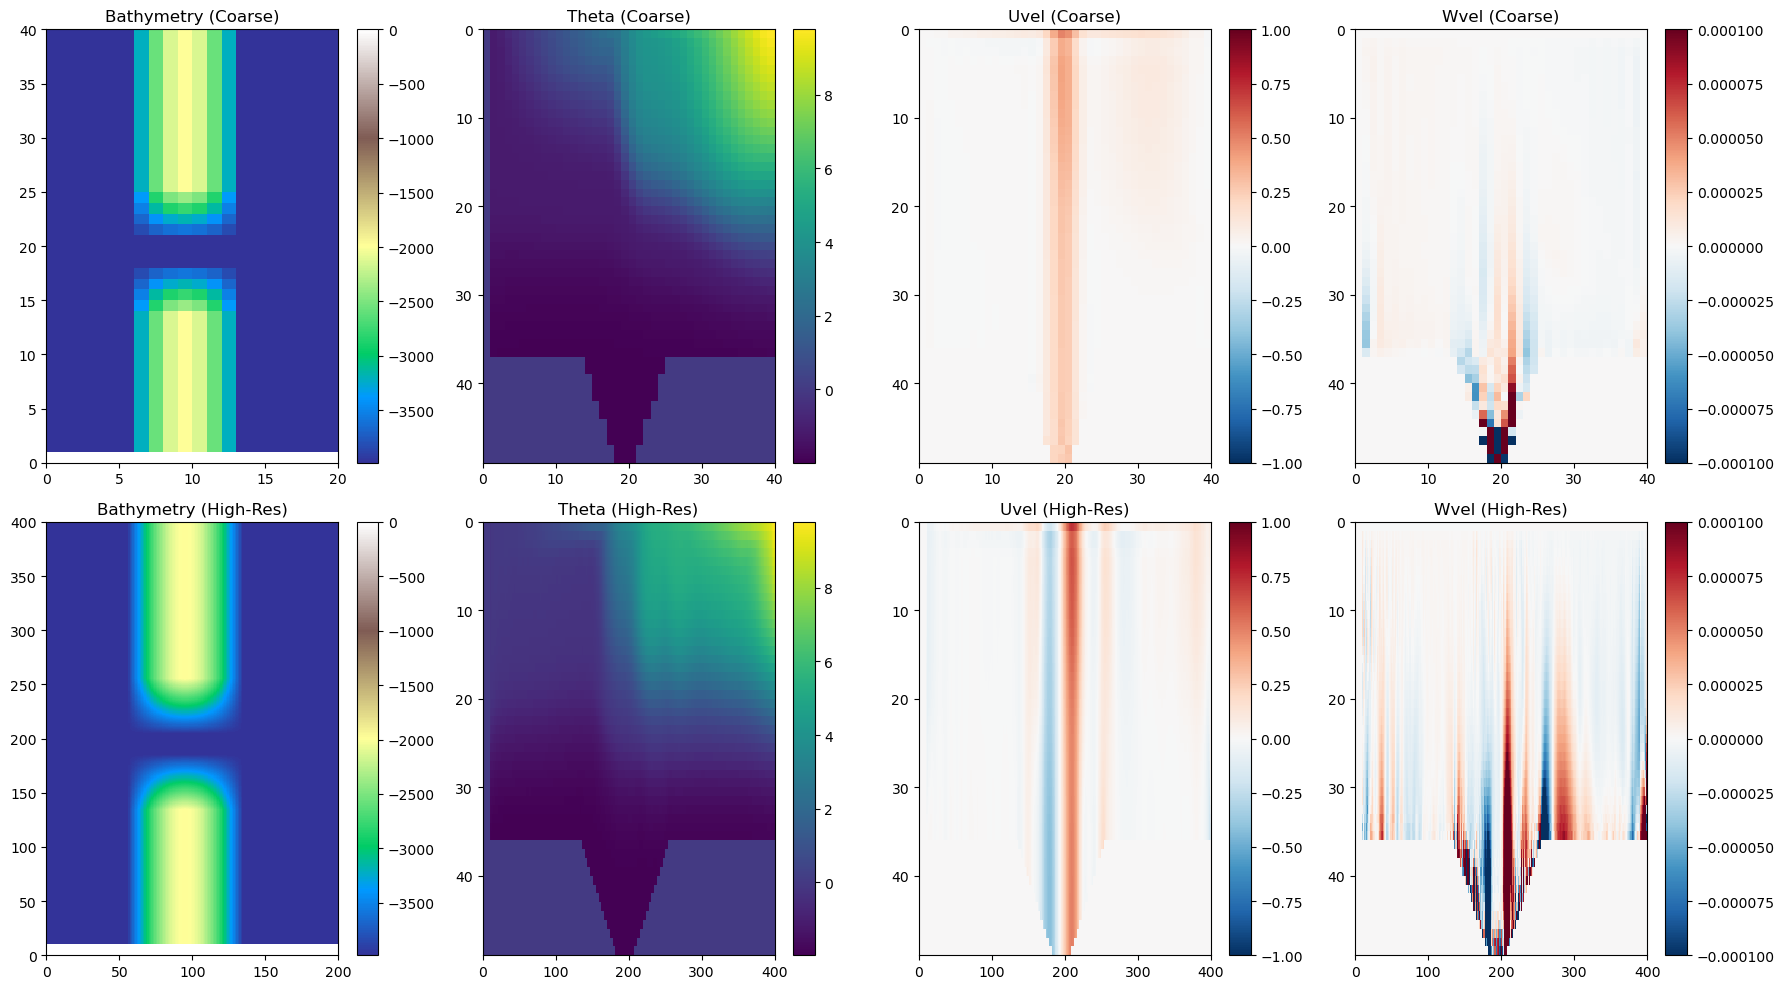

In [2]:
model_folder = '/Users/alex/Desktop/MS274/model'
hires_folder = '/Users/alex/Desktop/MS274/hires'

n_rows, n_cols = 40, 20
nr_hr, nc_hr = 400, 200
Nr = 49

bathy_file = os.path.join(model_folder, 'run', 'bathy.50km.bin')
bathy_grid = np.fromfile(bathy_file, '>f4').reshape((n_rows, n_cols))

bathy_file_hr = os.path.join(hires_folder, 'run', 'bathy.5km.bin')
bathy_grid_hr = np.fromfile(bathy_file_hr, '>f4').reshape((nr_hr, nc_hr))

def read_3D_conditions_from_file(f, Nr, n_rows, n_cols):
    d = np.fromfile(f, '>f4').reshape((4, Nr, n_rows, n_cols))
    return d[0], d[2], d[1], d[3]

init_i = 873504
end_i = 933120
step = 2592
it_nums = np.arange(init_i, end_i + step, step)

init_i_hr = 3494016
end_i_hr = 3732480
step_hr = 10368
it_nums_hr = np.arange(init_i_hr, end_i_hr + step_hr, step_hr)

def avg_files(iters, folder, Nr, n_rows, n_cols, hires=False):
    sT = sU = sV = sW = None
    path = os.path.join(folder, 'Diags') if hires else os.path.join(folder, 'run', 'Diags')
    for i in iters:
        f = os.path.join(path, f"state_monthly.{i:010d}.data")
        T, U, V, W = read_3D_conditions_from_file(f, Nr, n_rows, n_cols)
        if sT is None:
            sT = np.zeros_like(T)
            sU = np.zeros_like(U)
            sV = np.zeros_like(V)
            sW = np.zeros_like(W)
        sT += T
        sU += U
        sV += V
        sW += W
    n = len(iters)
    return sT/n, sU/n, sV/n, sW/n

avg_theta, avg_uvel, avg_vvel, avg_wvel = avg_files(it_nums, model_folder, Nr, n_rows, n_cols)
avg_theta_hr, avg_uvel_hr, avg_vvel_hr, avg_wvel_hr = avg_files(it_nums_hr, hires_folder, Nr, nr_hr, nc_hr, hires=True)

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
icol = n_cols // 2
icol_hr = nc_hr // 2

im0 = axes[0,0].pcolormesh(bathy_grid, cmap='terrain')
axes[0,0].set_title("Bathymetry (Coarse)")
fig.colorbar(im0, ax=axes[0,0])

im1 = axes[0,1].pcolormesh(avg_theta[:,:,icol], cmap='viridis')
axes[0,1].set_title("Theta (Coarse)")
axes[0,1].invert_yaxis()
fig.colorbar(im1, ax=axes[0,1])

im2 = axes[0,2].pcolormesh(avg_uvel[:,:,icol], cmap='RdBu_r', vmin=-1, vmax=1)
axes[0,2].set_title("Uvel (Coarse)")
axes[0,2].invert_yaxis()
fig.colorbar(im2, ax=axes[0,2])

im3 = axes[0,3].pcolormesh(avg_wvel[:,:,icol], cmap='RdBu_r', vmin=-0.0001, vmax=0.0001)
axes[0,3].set_title("Wvel (Coarse)")
axes[0,3].invert_yaxis()
fig.colorbar(im3, ax=axes[0,3])

im4 = axes[1,0].pcolormesh(bathy_grid_hr, cmap='terrain')
axes[1,0].set_title("Bathymetry (High-Res)")
fig.colorbar(im4, ax=axes[1,0])

im5 = axes[1,1].pcolormesh(avg_theta_hr[:,:,icol_hr], cmap='viridis')
axes[1,1].set_title("Theta (High-Res)")
axes[1,1].invert_yaxis()
fig.colorbar(im5, ax=axes[1,1])

im6 = axes[1,2].pcolormesh(avg_uvel_hr[:,:,icol_hr], cmap='RdBu_r', vmin=-1, vmax=1)
axes[1,2].set_title("Uvel (High-Res)")
axes[1,2].invert_yaxis()
fig.colorbar(im6, ax=axes[1,2])

im7 = axes[1,3].pcolormesh(avg_wvel_hr[:,:,icol_hr], cmap='RdBu_r', vmin=-0.0001, vmax=0.0001)
axes[1,3].set_title("Wvel (High-Res)")
axes[1,3].invert_yaxis()
fig.colorbar(im7, ax=axes[1,3])

plt.tight_layout()
plt.savefig("ridge_cross_sections_comparison.png", dpi=300)
plt.show()

## Part 5: Model Differences
In the markdown cell below, write a paragraph describing the differences in the model runs that resulted from changing the resolution. Some key questions to consider:
- What are the key changes to the model output?
- What causes the variabiliy in the higher resolution model that was not present in the lower resolution model? Note here that the external forcing conditions are identical!
- What is consistent between the model runs?
- How well do you think the low resolution model captures the features of the higher resolution model?
- What generalizations can we make about coarse resolution global ocean models based on this comparison?

The key changes in the model output are opposite-sign jets of zonal velocity near the center of the domain, more detailed spikes in vertical velocity, and finer-scale potential temperature structure. I think since this is an eddy-resolving simulation, some of these changes could be due to eddies, but others may simply be due to better resolving the bathymetry and more accurate numerical results. Theta and WVEL are generally consistent, just more "zoomed in" and finer scale, while UVEL exhibits a change in structure. I think it generally captures the temperature structure quite well, velocity fields less so. I think we can say that we should be skeptical of coarse resolution global ocean models and try to run or seek out output/data from higher resolution model runs or state estimates when possible.